# Labor 2

Mint eddig láttuk, a CUDA (Compute Unified Device Architecture) egy párhuzamos számítási platform és [heterogén programozási](https://en.wikipedia.org/wiki/Heterogeneous_computing) modell. A heterogén számítástechnika olyan rendszerekre vonatkozik, amelyek több fajta számítási eszközt, processzort használnak. Ezek esetében a teljesítménynövekedést nem csak az azonos típusú processzorok hozzáadásával érhetjük el, hanem eltérő processzorok használatával is, amelyek általában speciális feldolgozási képességekkel rendelkeznek, bizonyos típusú feladatok hatékony és eredményes kezelésére. Például a grafikus feldolgozó egységek és a CUDA adatpárhuzamos (az egyes processzorokon futó programok ebben az esetben azonosak, csak az általuk feldolgozott adatok különböznek) feladatok megoldására alkalmas igazán.

A CUDA lehetővé teszi a programjaink számára, hogy bizonyos típusú grafikus feldolgozó egységeket (GPU) használjanak általános célú számításokhoz, feldolgozáshoz, közvetlen hozzáférést biztosítva a GPU virtuális utasításkészletéhez és párhuzamos számítási elemeihez a számítási kernelek végrehajtásához.

A kernel, vagy GPU kód párhuzamosan több szálon futtatott programrészt jelent. Mivel a GPU egy különálló rendszer, saját memóriával, egy tipikus CUDA program a következő lépéseken kell végighaladjon:

1. **Memória lefoglalása az eszközön**
   - [`cudaMalloc`](https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__MEMORY.html#group__CUDART__MEMORY_1g37d37965bfb4803b6d4e59ff26856356)

2. **Gazda memóriából másolás az eszközre**
   - [`cudaMemcpy`](https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__MEMORY.html#group__CUDART__MEMORY_1gc263dbe6574220cc776b45438fc351e8), `cudaMemcpyKind kind = cudaMemcpyHostToDevice`

3. **Szálblokk és a kernel rács méreteinek meghatározása**

4. **A CUDA kernel meghívása**
   - `kernel<<<blocks, threadsPerBlock>>>(...)`

5. **Szinkronizáció**
   - [`cudaDeviceSynchronize();`](https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__DEVICE.html#group__CUDART__DEVICE_1g10e20b05a95f638a4071a655503df25d)

   A `cudaDeviceSynchronize()` szükséges, mert a CUDA kernel aszinkron módon indul el, vagyis a CPU folytatná a végrehajtást anélkül, hogy megvárná a GPU számításainak befejezését. Ha azonnal másolnánk az adatokat az eszközről a gazdagép memóriájába, akkor az eredmények még nem feltétlenül állnának rendelkezésre, ami helytelen működéshez vagy memóriasérüléshez vezethet. A `cudaDeviceSynchronize()` biztosítja, hogy a kernel végrehajtása teljesen befejeződjön, mielőtt a további műveletek megtörténnek.

6. **Eredmények másolása az eszközről a gazdagép memóriájába**
   - [`cudaMemcpy`](https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__MEMORY.html#group__CUDART__MEMORY_1gc263dbe6574220cc776b45438fc351e8), `cudaMemcpyKind kind = cudaMemcpyDeviceToHost`

7. **Memória felszabadítása a GPU-n**
   - [`cudaFree`](https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__MEMORY.html#group__CUDART__MEMORY_1ga042655cbbf3408f01061652a075e094)



## CUDA szálak szervezése

A CUDA programozásban a szálak szervezése kulcsfontosságú a hatékony és jól érthető párhuzamos feldolgozás szempontjából.

A CUDA egy speciális `dim3` nevű struktúrát biztosít a többdimenziós indexeléshez:

```cpp
struct dim3 {
    unsigned int x, y, z;
    // Alapértelmezetten: (1,1,1)
};
```

Ez a struktúra lehetővé teszi a szálak és blokkok szervezését akár 3 dimenzióban, ami különösen hasznos többdimenziós problémák (pl. képfeldolgozás, mátrix műveletek) esetén.

### Szálak hierarchikus szervezése

A CUDA két szinten szervezi a szálakat:

1. **Blokkok** (thread blocks): Szálak csoportjai, amelyek ugyanazon az SM-en (Streaming Multiprocessor) futnak
2. **Rácsok** (grids): Blokkok csoportjai, amelyek egy kernelt hajtanak végre

Amikor egy kernelt elindítunk, meghatározzuk a rács és a blokk méreteit:

```cpp
dim3 blockDim(16, 16, 1);  // 16x16 szál blokkonként (2D)
dim3 gridDim(ceil(N/16.0), ceil(N/16.0), 1);  // Elegendő blokk a teljes adathoz

myKernel<<<gridDim, blockDim>>>(adatok, N);
```




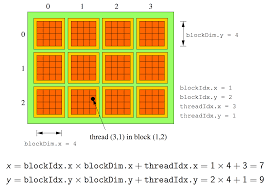


Ábra 1. Szálak hierarchikus szervezése. [Forrás](https://www.ce.jhu.edu/dalrymple/classes/602/Class10.pdf)

### Indexelés a kernelek belsejében

A kernelen belül a CUDA beépített változókat biztosít a szálak azonosítására:

```cpp
// Blokkon belüli szál azonosítók
threadIdx.x, threadIdx.y, threadIdx.z

// Blokk azonosítók a rácsban
blockIdx.x, blockIdx.y, blockIdx.z

// Blokk és rács dimenziók
blockDim.x, blockDim.y, blockDim.z
gridDim.x, gridDim.y, gridDim.z
```

### A többdimenziós logikai szervezés előnyei

Bár az adatok linearizált memóriában vannak tárolva (pl. `float* adatok`), a többdimenziós indexelés számos előnnyel jár:

1. **Természetes problémaleképezés**: A legtöbb párhuzamos probléma természetesen többdimenziós (pl. képek, mátrixok)

2. **Könnyebb kód olvashatóság**: A 2D vagy 3D indexelés intuitívabb, mint a linearizált indexek

3. **Hatékonyabb memóriaelérés**: A megfelelő szálszervezéssel optimalizálhatjuk a memória koaleszcenciát

## Példa: 2D mátrix feldolgozás

Tegyük fel, hogy egy NxN mátrixot dolgozunk fel:

```cpp
__global__ void matrixKernel(float* A, int N) {
    // Kiszámítjuk a 2D indexeket
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    
    if (row < N && col < N) {
        // Linearizáljuk az indexet a memóriaművelethez
        int idx = row * N + col;
        
        // Mátrix feldolgozás
        A[idx] = valamiSzámítás(A[idx]);
    }
}

// Kernel indítása
dim3 threadsPerBlock(16, 16);
dim3 numBlocks((N + threadsPerBlock.x - 1) / threadsPerBlock.x,
               (N + threadsPerBlock.y - 1) / threadsPerBlock.y);
matrixKernel<<<numBlocks, threadsPerBlock>>>(d_A, N);
```

Figyeljük meg, hogyan:
1. Definiáljuk a logikai szálszervezést a `dim3` használatával
2. Számítjuk ki a 2D koordinátákat a kernelen belül
3. Linearizáljuk ezeket a koordinátákat a memória eléréséhez (az Adatstruktúránk `float* A`)

## A blokkméretek kiválasztásának szempontjai

A hatékony szálszervezéshez figyelembe kell venni a következőket:

- **Warp méret**: A CUDA 32 szálat csoportosít warpokba, így a blokkméret legyen 32 többszöröse (pl. 128, 256)
- **Foglaltság**: Túl nagy blokkok csökkenthetik az SM foglaltságot
- **Közös memória**: A közös memória korlátozhatja a blokkméretet
- **Memória koaleszcencia**: A közeli szálak hasonló memóriacímeket érjenek el


A dim3 struktúra és a CUDA szálszervezési modellje lehetővé teszi a szálak logikai szervezését, miközben a tényleges adatokat linearizált tömbökben tároljuk. Ez az absztrakció segít a programozóknak intuitívabb módon gondolkodni a párhuzamos problémákról, miközben kihasználják a GPU hardver sajátosságait a maximális teljesítmény érdekében.




## Példa

A példaprogram egy értéklevágó (value clipper) implementációját mutatja be, amely CUDA heterogén számítási környezetben működik. A program egy egyszerű, de fontos feladatot old meg: értékeket korlátoz egy megadott tartományra (jelen esetben 0 és 255 közé, `float f_also, float f_felso`).

Figyeljük meg, ismételjük át a heterogén számítási koncepciók megvalósítását: hogyan történik a memóriafoglalás külön a CPU-n (host) és GPU-n (device), hogyan másolunk adatokat a két eszköz között, hogyan konfigurálunk és indítunk egy CUDA kernelt, valamint hogyan működik a párhuzamos végrehajtási modell.


Tanulmányozzák a szálak indexelését, a blokkok és szálak konfigurációját, és hogyan biztosítjuk a helyes szinkronizációt a műveletek között. Figyeljük meg  az `if (i_idx < n_elemSzam)` ellenőrzést, amely garantálja, hogy csak érvényes memóriaterülethez férünk hozzá – ez a határellenőrzés elengedhetetlen a memóriasértések és nem definiált viselkedés elkerülése érdekében, mivel a CUDA blokkméretei miatt gyakran több szálat indítunk, mint ahány elemünk valójában van.

Általában miért nem indíthatunk pontosan annyi szálat, ahány adatelemünk van? A CUDA architektúra warp-okban (általában 32 szál) és blokkokban szervezi a végrehajtást, így a szálak számát a blokkméretek egész többszöröseire kell kerekítenünk. Emiatt használjuk a `(n_elemSzam + i_szalakSzamaBlokkonkent - 1) / i_szalakSzamaBlokkonkent` képletet a szükséges blokkok számának meghatározásához, ami általában több szálat eredményez, mint az adatok mennyisége, mindig szükségessé téve az index-ellenőrzést a kernelben.

```cpp
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>
          
// Elemek száma (Number of elements)
#define n_elemSzam 10

// CUDA kernel függvény az értékek levágására
// (CUDA kernel function for clipping values)
__global__ void clipValuesKernel(float* d_adatok, int n, float f_also, float f_felso) {
    // A szál indexének kiszámítása
    // (Calculate thread index)
    int i_idx = blockIdx.x * blockDim.x + threadIdx.x;
    
    // Ellenőrizzük, hogy a szál indexe érvényes-e
    // (Check if thread index is valid)
    if (i_idx < n) {
        // Értékek levágása a megadott tartományba
        // (Clip values to the specified range)
        if (d_adatok[i_idx] < f_also) {
            d_adatok[i_idx] = f_also;
        }
        else if (d_adatok[i_idx] > f_felso) {
            d_adatok[i_idx] = f_felso;
        }
    }
}

int main() {
    // Bemeneti paraméterek
    // (Input parameters)
    
    float f_also = 0.0f;           // Alsó határ (Lower bound)
    float f_felso = 255.0f;        // Felső határ (Upper bound)
    
    size_t sz_meret = n_elemSzam * sizeof(float);
    
    float h_bemenet[n_elemSzam];
    float h_kimenet[n_elemSzam];
    
    // Minta bemeneti adatok létrehozása
    // (Create sample input data)
    printf("Eredeti értékek (Original values):\n");
    for (int i = 0; i < n_elemSzam; i++) {
        // -100 és 400 közötti véletlenszerű értékek generálása
        // (Generate random values between -100 and 400)
        h_bemenet[i] = ((float)rand() / RAND_MAX) * 500.0f - 100.0f;
        printf("%.2f ", h_bemenet[i]);
    }
    printf("\n");
    
    // GPU memória (device) foglalása - HETEROGÉN SZÁMÍTÁS KEZDETE
    // (Allocate GPU memory (device) - BEGINNING OF HETEROGENEOUS COMPUTING)
    float* d_adatok;
    cudaMalloc((void**)&d_adatok, sz_meret);
    
    // Adatok másolása a host-ról a device-ra
    // (Copy data from host to device)
    cudaMemcpy(d_adatok, h_bemenet, sz_meret, cudaMemcpyHostToDevice);
    
    // CUDA kernel konfigurálása és futtatása
    // (Configure and run CUDA kernel)
    int i_szalakSzamaBlokkonkent = 256;
    int i_blokkokSzama = (n_elemSzam + i_szalakSzamaBlokkonkent - 1) / i_szalakSzamaBlokkonkent;
    
    // Kernel futtatása a GPU-n
    // (Run kernel on GPU)
    clipValuesKernel<<<i_blokkokSzama, i_szalakSzamaBlokkonkent>>>(d_adatok, n_elemSzam, f_also, f_felso);
    
    // Várakozás a kernel befejezésére
    // (Wait for kernel to complete)
    cudaDeviceSynchronize();
    
    // Eredmények másolása a device-ról vissza a host-ra
    // (Copy results from device back to host)
    cudaMemcpy(h_kimenet, d_adatok, sz_meret, cudaMemcpyDeviceToHost);
    
    // GPU memória felszabadítása
    // (Free GPU memory)
    cudaFree(d_adatok);
    // HETEROGÉN SZÁMÍTÁS VÉGE
    // (END OF HETEROGENEOUS COMPUTING)
    
    // Eredmények kiírása
    // (Print results)
    printf("Levágott értékek (Clipped values) [%.2f, %.2f]:\n", f_also, f_felso);
    for (int i = 0; i < n_elemSzam; i++) {
        printf("%.2f ", h_kimenet[i]);
    }
    printf("\n");
    
    return 0;
}

```

# Képek olvasása

Az ingyenes [CImg Library](https://cimg.eu) egy egyszerű, könnyen használható C++ könyvtár, amely lehetővé teszi a képek manipulálását, feldolgozását és megjelenítését. A könyvtár könnyen telepíthető és használható a fejlesztők számára, és számos képfeldolgozási feladatot meg lehet vele oldani.

Példa kód a CImg Library használatára, kép beolvasására majd kiírására:

```cpp
#include <iostream>
#include "CImg.h"

using namespace cimg_library;

int main() {
  CImg<unsigned char> image("example.jpg"); // kép betöltése
  image.blur(2.5); // elmosás
  image.save("blurred.jpg"); // elmosott kép mentése

  return 0;
}
```


A telepítéshez a Google Colab környezetben, használjuk a köcetkező parancsot:

In [22]:
!apt-get install cimg-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libxrandr-dev
Suggested packages:
  xmedcon lapack3-dev cimg-doc cimg-examples libgraphicsmagick++1-dev
  | libmagick++-dev libfftw3-dev | fftw3-dev libgimp2.0-dev libhighgui-dev
  libtiff5-dev
The following NEW packages will be installed:
  cimg-dev libxrandr-dev
0 upgraded, 2 newly installed, 0 to remove and 41 not upgraded.
Need to get 554 kB of archives.
After this operation, 5,537 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxrandr-dev amd64 2:1.5.2-1build1 [26.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 cimg-dev all 2.9.4+dfsg-3 [527 kB]
Fetched 554 kB in 1s (874 kB/s)
Selecting previously unselected package libxrandr-dev:amd64.
(Reading database ... 125082 files and directories currently installed.)
Preparing to unpack .../libxrandr-dev_2%3a1.5.2-1build

A [wget](https://www.gnu.org/software/wget/) parancs segítségével töltsünk le egy képet, melyet majd fel fogunk dolgozni:

In [23]:
!wget --no-check-certificate -O image.jpg https://images.unsplash.com/photo-1570641963303-92ce4845ed4c?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=987&q=80

--2025-11-10 12:59:11--  https://images.unsplash.com/photo-1570641963303-92ce4845ed4c?ixlib=rb-4.0.3
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4675983 (4.5M) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]   4.46M  --.-KB/s    in 0.05s   

2025-11-10 12:59:11 (82.5 MB/s) - ‘image.jpg’ saved [4675983/4675983]



A `CImg` osztály `data()` metódusa lehetővé teszi a képpixelekhez való közvetlen hozzáférést. A `data()` metódus egy pointert térit vissza, amely az első pixelre mutat.  Az adatok típusa az unsigned char tömb, és a képpontok sorfolytonosan, színkanálisónként íródnak. Tehát, nem átlapoltan `RGBRGBRGB...` formában, hanem előszőr a pixelek vörös intenzitása, majd a zöld aztán a kék: `RRRR...GGGG...BBBB`.

Az alábbi példa bemutatja, hogy a `data()` metódus használatával, hogyan tudjuk a képontokat direkt módon elérni, és egy képet szürkeárnyalatuvá alakítani:

In [24]:
%%writefile grayscale.cu
#define cimg_use_jpeg
#include "CImg.h"
#include <iostream>

using namespace cimg_library;
using namespace std;

void grayscale_cpu(unsigned char *r, unsigned char *g, unsigned char *b, unsigned char *grayimg, int width, int height, float wR, float wG){
    for (int row = 0; row < height; row++)
      for (int col = 0; col < width; col++) {
        int offset = row*width + col;
        unsigned val = wR*r[offset] + wG*g[offset] + (1-wR-wG)*b[offset];
        grayimg[offset] = val;
      }
}

int main() {
  CImg<unsigned char> src("./image.jpg");

  int width = src.width();
  int height = src.height();
  cout << width << "x" << height << endl;

  unsigned char *r = src.data();
  unsigned char *g = r + width*height;
  unsigned char *b = g + width*height;;

  int numberOfColorChannels = 1;
  CImg<unsigned char> dest(width, height, 1, numberOfColorChannels);

  unsigned char * gray = dest.data();

  grayscale_cpu(r,g,b,gray,width,height,0.3f,0.59f);
  cout  << "Saving grayscale output\n";

  //dest.save_jpeg("./grayscale.jpg", 95);
  dest.save_pnm("result.pgm");

  return 0;
}

Writing grayscale.cu


Kompilálás:

In [25]:
!nvcc grayscale.cu -lpthread -lX11 -ljpeg

Futtatás:

In [26]:
!./a.out

4000x6000
Saving grayscale output


In [27]:
!ls

a.out	      grayscale_gpu.cu	matrix_sum.cu  sample_data
grayscale.cu  image.jpg		result.pgm


## CUDA feldolgozás pálda

A példa bemutatja, hogyan használhatjuk a CUDA-t 2D szálfeldolgozással képek generálására és feldolgozására a CImg könyvtár segítségével. A kód két különböző képet generál:

1. **Szürkeárnyalatú kép** - egyetlen csatornával, ahol a pixel értékek az x és y koordináták alapján változnak
2. **Színes kép** - három csatornával (RGB), ahol:
   - A piros komponens az x koordinátától függ
   - A zöld komponens az y koordinátától függ
   - A kék komponens az átlós pozíciótól függ

### Fontosabb részletek:

- **2D szálszervezés**: Mindkét kernel 2D blokkokkal és rácsokkal dolgozik
- **Koordináták kiszámítása**: A `blockIdx`, `blockDim` és `threadIdx` változókat használjuk a pixel koordináták meghatározásához
- **Linearizálás**: A többdimenziós koordinátákat linearizáljuk a memória (képadatok) eléréséhez
- **CImg integráció**: Bemutatásra kerül, hogyan lehet CImg-t használni a képek létrehozásához és mentéséhez

Figyeljük meg, hogyan történik a logikai koordináták és a linearizált memória közötti átalakítás.

```cpp
# define cimg_use_jpeg
# include "CImg.h"
# include <cuda_runtime.h>
# include <iostream>

using namespace cimg_library;

// Kernel a szürkeárnyalatú kép kitöltésére (színátmenet)
__global__ void fillGrayscaleImage(unsigned char* data, int width, int height) {
    // 2D thread indexek számítása
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    
    // Ellenőrizzük, hogy a szálidex a kép határain belül van-e
    if (x < width && y < height) {
        // Linearizált index számítása a memóriához
        int idx = y * width + x;
        
        // Színátmenet létrehozása az x és y koordináták alapján
        // Értékek 0-255 között
        unsigned char value = (unsigned char)(255.0f * (float)x / width * (float)y / height);
        
        // Pixel érték beállítása
        data[idx] = value;
    }
}

// Kernel a színes kép kitöltésére (RGB)
__global__ void fillColorImage(unsigned char* data, int width, int height) {
    // 2D thread indexek számítása
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    
    // Ellenőrizzük, hogy a szálidex a kép határain belül van-e
    if (x < width && y < height) {
        // Linearizált index számítása az egyes színcsatornáknál
        // A CImg tárolási módja: RRRR...GGGG...BBBB
        int pixelIndex = y * width + x;
        int totalPixels = width * height;
        
        // Piros komponens - x-től függ (az első csatorna a 0 offsettel kezdődik)
        data[pixelIndex] = (unsigned char)(255.0f * (float)x / width);
        
        // Zöld komponens - y-tól függ (a második csatorna a totalPixels offsettel kezdődik)
        data[pixelIndex + totalPixels] = (unsigned char)(255.0f * (float)y / height);
        
        // Kék komponens - x és y átlójától függ (a harmadik csatorna a 2*totalPixels offsettel kezdődik)
        float diagonal = (float)(x + y) / (width + height);
        data[pixelIndex + 2 * totalPixels] = (unsigned char)(255.0f * diagonal);
    }
}

// Hibakezelő segédfüggvény
void checkCudaError(cudaError_t err, const char* msg) {
    if (err != cudaSuccess) {
        std::cerr << "CUDA Error: " << msg << " - " << cudaGetErrorString(err) << std::endl;
        exit(EXIT_FAILURE);
    }
}

int main() {
    // Kép méretek
    const int width = 512;
    const int height = 512;
    cudaError_t err;
    
    // 1. Szürkeárnyalatú kép
    {
        // Szürkeárnyalatú kép létrehozása (1 színcsatorna)
        CImg<unsigned char> grayscaleImg(width, height, 1, 1);
        
        // Memória foglalása a GPU-n
        unsigned char* d_data;
        size_t grayscaleSize = width * height * sizeof(unsigned char);
        err = cudaMalloc(&d_data, grayscaleSize);
        checkCudaError(err, "Nem sikerült memóriát foglalni a szürkeárnyalatú képhez");
        
        // Inicializáljuk nullákkal a GPU memóriát
        err = cudaMemset(d_data, 0, grayscaleSize);
        checkCudaError(err, "Nem sikerült inicializálni a GPU memóriát");
        
        // Thread és block méretek beállítása
        dim3 threadsPerBlock(16, 16);
        dim3 numBlocks((width + threadsPerBlock.x - 1) / threadsPerBlock.x,
                      (height + threadsPerBlock.y - 1) / threadsPerBlock.y);
        
        // Kernel futtatása
        fillGrayscaleImage<<<numBlocks, threadsPerBlock>>>(d_data, width, height);
        err = cudaGetLastError();
        checkCudaError(err, "Kernel futtatási hiba (szürkeárnyalatú)");
        
        // Várakozás a kernel befejezésére
        err = cudaDeviceSynchronize();
        checkCudaError(err, "Szinkronizációs hiba");
        
        // Adatok visszamásolása a GPU-ról
        err = cudaMemcpy(grayscaleImg.data(), d_data, grayscaleSize, cudaMemcpyDeviceToHost);
        checkCudaError(err, "Memória másolási hiba (device to host)");
        
        // GPU memória felszabadítása
        cudaFree(d_data);
        
        // Kép mentése
        grayscaleImg.save_pnm("grayscale_result.pgm");
        std::cout << "Szürkeárnyalatú kép elkészült: grayscale_result.pgm" << std::endl;
    }
    
    // 2. Színes kép
    {
        // Színes kép létrehozása (3 színcsatorna: R, G, B)
        CImg<unsigned char> colorImg(width, height, 1, 3);
        
        // Memória foglalása a GPU-n
        unsigned char* d_data;
        size_t colorSize = width * height * 3 * sizeof(unsigned char);
        err = cudaMalloc(&d_data, colorSize);
        checkCudaError(err, "Nem sikerült memóriát foglalni a színes képhez");
        
        // Inicializáljuk nullákkal a GPU memóriát
        err = cudaMemset(d_data, 0, colorSize);
        checkCudaError(err, "Nem sikerült inicializálni a GPU memóriát");
        
        // Thread és block méretek beállítása
        dim3 threadsPerBlock(16, 16);
        dim3 numBlocks((width + threadsPerBlock.x - 1) / threadsPerBlock.x,
                      (height + threadsPerBlock.y - 1) / threadsPerBlock.y);
        
        // Kernel futtatása
        fillColorImage<<<numBlocks, threadsPerBlock>>>(d_data, width, height);
        err = cudaGetLastError();
        checkCudaError(err, "Kernel futtatási hiba (színes)");
        
        // Várakozás a kernel befejezésére
        err = cudaDeviceSynchronize();
        checkCudaError(err, "Szinkronizációs hiba");
        
        // Adatok visszamásolása a GPU-ról
        err = cudaMemcpy(colorImg.data(), d_data, colorSize, cudaMemcpyDeviceToHost);
        checkCudaError(err, "Memória másolási hiba (device to host)");
        
        // GPU memória felszabadítása
        cudaFree(d_data);
        
        // Kép mentése
        colorImg.save_pnm("color_result.ppm");
        std::cout << "Színes kép elkészült: color_result.ppm" << std::endl;
    }
    
    return 0;
}
```

In [28]:
%%writefile cimgtest.cu

# define cimg_use_jpeg
# include "CImg.h"
# include <cuda_runtime.h>
# include <iostream>

using namespace cimg_library;

// Kernel a szürkeárnyalatú kép kitöltésére (színátmenet)
__global__ void fillGrayscaleImage(unsigned char* data, int width, int height) {
    // 2D thread indexek számítása
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    // Ellenőrizzük, hogy a szálidex a kép határain belül van-e
    if (x < width && y < height) {
        // Linearizált index számítása a memóriához
        int idx = y * width + x;

        // Színátmenet létrehozása az x és y koordináták alapján
        // Értékek 0-255 között
        unsigned char value = (unsigned char)(255.0f * (float)x / width * (float)y / height);

        // Pixel érték beállítása
        data[idx] = value;
    }
}

// Kernel a színes kép kitöltésére (RGB)
__global__ void fillColorImage(unsigned char* data, int width, int height) {
    // 2D thread indexek számítása
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    // Ellenőrizzük, hogy a szálidex a kép határain belül van-e
    if (x < width && y < height) {
        // Linearizált index számítása az egyes színcsatornáknál
        // A CImg tárolási módja: RRRR...GGGG...BBBB
        int pixelIndex = y * width + x;
        int totalPixels = width * height;

        // Piros komponens - x-től függ (az első csatorna a 0 offsettel kezdődik)
        data[pixelIndex] = (unsigned char)(255.0f * (float)x / width);

        // Zöld komponens - y-tól függ (a második csatorna a totalPixels offsettel kezdődik)
        data[pixelIndex + totalPixels] = (unsigned char)(255.0f * (float)y / height);

        // Kék komponens - x és y átlójától függ (a harmadik csatorna a 2*totalPixels offsettel kezdődik)
        float diagonal = (float)(x + y) / (width + height);
        data[pixelIndex + 2 * totalPixels] = (unsigned char)(255.0f * diagonal);
    }
}

// Hibakezelő segédfüggvény
void checkCudaError(cudaError_t err, const char* msg) {
    if (err != cudaSuccess) {
        std::cerr << "CUDA Error: " << msg << " - " << cudaGetErrorString(err) << std::endl;
        exit(EXIT_FAILURE);
    }
}

int main() {
    // Kép méretek
    const int width = 512;
    const int height = 512;
    cudaError_t err;

    // 1. Szürkeárnyalatú kép
    {
        // Szürkeárnyalatú kép létrehozása (1 színcsatorna)
        CImg<unsigned char> grayscaleImg(width, height, 1, 1);

        // Memória foglalása a GPU-n
        unsigned char* d_data;
        size_t grayscaleSize = width * height * sizeof(unsigned char);
        err = cudaMalloc(&d_data, grayscaleSize);
        checkCudaError(err, "Nem sikerült memóriát foglalni a szürkeárnyalatú képhez");

        // Inicializáljuk nullákkal a GPU memóriát
        err = cudaMemset(d_data, 0, grayscaleSize);
        checkCudaError(err, "Nem sikerült inicializálni a GPU memóriát");

        // Thread és block méretek beállítása
        dim3 threadsPerBlock(16, 16);
        dim3 numBlocks((width + threadsPerBlock.x - 1) / threadsPerBlock.x,
                      (height + threadsPerBlock.y - 1) / threadsPerBlock.y);

        // Kernel futtatása
        fillGrayscaleImage<<<numBlocks, threadsPerBlock>>>(d_data, width, height);
        err = cudaGetLastError();
        checkCudaError(err, "Kernel futtatási hiba (szürkeárnyalatú)");

        // Várakozás a kernel befejezésére
        err = cudaDeviceSynchronize();
        checkCudaError(err, "Szinkronizációs hiba");

        // Adatok visszamásolása a GPU-ról
        err = cudaMemcpy(grayscaleImg.data(), d_data, grayscaleSize, cudaMemcpyDeviceToHost);
        checkCudaError(err, "Memória másolási hiba (device to host)");

        // GPU memória felszabadítása
        cudaFree(d_data);

        // Kép mentése
        grayscaleImg.save_pnm("grayscale_result.pgm");
        std::cout << "Szürkeárnyalatú kép elkészült: grayscale_result.pgm" << std::endl;
    }

    // 2. Színes kép
    {
        // Színes kép létrehozása (3 színcsatorna: R, G, B)
        CImg<unsigned char> colorImg(width, height, 1, 3);

        // Memória foglalása a GPU-n
        unsigned char* d_data;
        size_t colorSize = width * height * 3 * sizeof(unsigned char);
        err = cudaMalloc(&d_data, colorSize);
        checkCudaError(err, "Nem sikerült memóriát foglalni a színes képhez");

        // Inicializáljuk nullákkal a GPU memóriát
        err = cudaMemset(d_data, 0, colorSize);
        checkCudaError(err, "Nem sikerült inicializálni a GPU memóriát");

        // Thread és block méretek beállítása
        dim3 threadsPerBlock(16, 16);
        dim3 numBlocks((width + threadsPerBlock.x - 1) / threadsPerBlock.x,
                      (height + threadsPerBlock.y - 1) / threadsPerBlock.y);

        // Kernel futtatása
        fillColorImage<<<numBlocks, threadsPerBlock>>>(d_data, width, height);
        err = cudaGetLastError();
        checkCudaError(err, "Kernel futtatási hiba (színes)");

        // Várakozás a kernel befejezésére
        err = cudaDeviceSynchronize();
        checkCudaError(err, "Szinkronizációs hiba");

        // Adatok visszamásolása a GPU-ról
        err = cudaMemcpy(colorImg.data(), d_data, colorSize, cudaMemcpyDeviceToHost);
        checkCudaError(err, "Memória másolási hiba (device to host)");

        // GPU memória felszabadítása
        cudaFree(d_data);

        // Kép mentése
        colorImg.save_pnm("color_result.ppm");
        std::cout << "Színes kép elkészült: color_result.ppm" << std::endl;
    }

    return 0;
}

Writing cimgtest.cu


In [29]:
!nvcc -arch=sm_75 cimgtest.cu -lpthread -lX11 -ljpeg

In [30]:
!./a.out

Szürkeárnyalatú kép elkészült: grayscale_result.pgm
Színes kép elkészült: color_result.ppm


GPU teszt:

In [31]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Feladatok

1. Futtassuk és ellemezük az fenti értéklevágó példát.
	* Hány globális memóriaolvasást hajt végre a kernel?
	* Mi az a maximális vektor méret amire még lefut a program?
	* Mit kell változtassunk a program szerkezetén, hogy akár több gigabájt memóriát is sikerüljön lefoglalni?

2. Írjunk egy CUDA programot mely kiszámolja két `N x N` négyzetes mátrix mellékátlóra szimmetrikus összegét:

	`C(x, y) = A(x, y) + B(N-x, N-y)`

	Pl.

	```
       _      _
      |11 13 15|
    A =|17 19 21|
      |23 25 27|
      -      -

        _      _
       |64 60 56|
    B =|52 48 44|
       |40 36 32|
       -      -

         _              _
        |11+32 13+36 15+40|
    C = |17+44 19+48 21+52|
        |23+56 25+60 27+64|
         -               -
	```




  Próbáljuk ki az egydimenziós és kétdimenziós rács és blokkszervezést is. Melyik esetben könnyebb megírni a kernelt?

3. A fentebb található példából kiindulva, írjunk egy CUDA programot, mely a GPU-n végzi el egy kép pixeleinek szürkeárnyalatú transzformálásának a műveleteit.
  
  Lépések:

  * memória lefoglalás az eszközön.
  * kép másolása az eszközre.
  * szálblokk és rács méreteinek, konfigurációjának a meghatározása.
  * CUDA kernel meghívása.
  * az eredmény másolása az eszközről a gazdagépre (host).
  memória felszabadítása az eszközön

1. Feladat:


> Hány globális memóriaolvasást hajt végre a kernel?

Minimum 1 és maximum 2.

> Mi az a maximális vektor méret amire még lefut a program?

10000000

> Mit kell változtassunk a program szerkezetén, hogy akár több gigabájt memóriát is sikerüljön lefoglalni?

Dinamikus host memória foglalás, hibakezeles, GPU memória felszabadítása, optimalizáció es a megfelelo memoriakezelés alkalmazása (pl: Stream-ek alkalmazása)

2. Feladat:

In [32]:
%%writefile matrix_sum.cu
#include <iostream>
#include <cuda_runtime.h>

void checkCudaErrors(cudaError_t err, const char* msg) {
    if (err != cudaSuccess) {
        std::cerr << "CUDA Error: " << msg << " - " << cudaGetErrorString(err) << std::endl;
        exit(EXIT_FAILURE);
    }
}

__global__ void matrixAdd2D(int* d_A, int* d_B, int* d_C, int N_matrix) {
    // Calculate 2D thread indices
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    int row = blockIdx.y * blockDim.y + threadIdx.y;

    if (row < N_matrix && col < N_matrix) {
        int linear_idx = row * N_matrix + col;

        int reflected_row = N_matrix - 1 - row;
        int reflected_col = N_matrix - 1 - col;

        int B_reflected_linear_idx = reflected_row * N_matrix + reflected_col;

        d_C[linear_idx] = d_A[linear_idx] + d_B[B_reflected_linear_idx];
    }
}

int main() {
    int n = 4;
    int h_A[n][n];
    int h_B[n][n];
    int h_C[n][n];

    int* d_A, *d_B, *d_C;
    size_t matrix_size = n * n * sizeof(int);

    printf("Matrix A:\n");
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            h_A[i][j] = (i * n + j) * 2 + 1;
            printf("%d\t", h_A[i][j]);
        }
        printf("\n");
    }

    printf("\nMatrix B:\n");
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            h_B[i][j] = (n * n) - (i * n + j) * 4;
            printf("%d\t", h_B[i][j]);
        }
        printf("\n");
    }

    // Allocate device memory
    checkCudaErrors(cudaMalloc((void**)&d_A, matrix_size), "Error while allocating device memory to matrix A");
    checkCudaErrors(cudaMalloc((void**)&d_B, matrix_size), "Error while allocating device memory to matrix B");
    checkCudaErrors(cudaMalloc((void**)&d_C, matrix_size), "Error while allocating device memory to matrix C");

    // Copy host matrices to device
    checkCudaErrors(cudaMemcpy(d_A, h_A, matrix_size, cudaMemcpyHostToDevice), "Error while copying matrix A to device");
    checkCudaErrors(cudaMemcpy(d_B, h_B, matrix_size, cudaMemcpyHostToDevice), "Error while copying matrix B to device");

    int threadsPerBlock_dim = 2;
    dim3 threadsPerBlock(threadsPerBlock_dim, threadsPerBlock_dim);
    dim3 numBlocks((n + threadsPerBlock.x - 1) / threadsPerBlock.x,
                   (n + threadsPerBlock.y - 1) / threadsPerBlock.y);

    // Launch kernel
    matrixAdd2D<<<numBlocks, threadsPerBlock>>>(d_A, d_B, d_C, n);
    checkCudaErrors(cudaGetLastError(), "Error while lunching kernel");

    checkCudaErrors(cudaDeviceSynchronize(), "Error while sycronizing");
    checkCudaErrors(cudaMemcpy(h_C, d_C, matrix_size, cudaMemcpyDeviceToHost), "Error while sycronizing");

    printf("\nMatrix C:\n");
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            printf("%d\t", h_C[i][j]);
        }
        printf("\n");
    }

    // Free device memory
    checkCudaErrors(cudaFree(d_A), "Error while freeing up device memory");
    checkCudaErrors(cudaFree(d_B), "Error while freeing up device memory");
    checkCudaErrors(cudaFree(d_C), "Error while freeing up device memory");

    return 0;
}

Overwriting matrix_sum.cu


In [33]:
!nvcc -arch=sm_75 matrix_sum.cu -lpthread -lX11 -ljpeg

In [34]:
!./a.out

Matrix A:
1	3	5	7	
9	11	13	15	
17	19	21	23	
25	27	29	31	

Matrix B:
16	12	8	4	
0	-4	-8	-12	
-16	-20	-24	-28	
-32	-36	-40	-44	

Matrix C:
-43	-37	-31	-25	
-19	-13	-7	-1	
5	11	17	23	
29	35	41	47	


3. Feladat:

In [40]:
%%writefile grayscale_gpu.cu
#define cimg_use_jpeg
#include "CImg.h"
#include <cuda_runtime.h>
#include <iostream>

using namespace cimg_library;

void checkCudaErrors(cudaError_t err, const char* msg) {
    if (err != cudaSuccess) {
        std::cerr << "CUDA Error: " << msg << " - " << cudaGetErrorString(err) << std::endl;
        exit(EXIT_FAILURE);
    }
}

__global__ void grayscale_gpu_kernel(unsigned char* d_input_rgb, unsigned char* d_output_gray, int width, int height, float wR, float wG) {

    int col = blockIdx.x * blockDim.x + threadIdx.x;
    int row = blockIdx.y * blockDim.y + threadIdx.y;

    if (col < width && row < height) {
        int pixelIndex = row * width + col;
        int totalPixels = width * height;

        unsigned char r = d_input_rgb[pixelIndex];
        unsigned char g = d_input_rgb[pixelIndex + totalPixels];
        unsigned char b = d_input_rgb[pixelIndex + 2 * totalPixels];

        unsigned char gray_val = (unsigned char)(wR * r + wG * g + (1.0f - wR - wG) * b);

        d_output_gray[pixelIndex] = gray_val;
    }
}

int main() {
    CImg<unsigned char> src("./image.jpg");

    int width = src.width();
    int height = src.height();
    int num_channels = src.spectrum();

    std::cout << "Image size: " << width << "x" << height << std::endl;

    if (num_channels != 3) {
        std::cerr << "The input haz to be an RGB image." << std::endl;
        return 1;
    }

    float wR = 0.3f;
    float wG = 0.59f;

    // Allocate device memory
    unsigned char* d_input_rgb;
    size_t input_size = width * height * num_channels * sizeof(unsigned char);
    checkCudaErrors(cudaMalloc((void**)&d_input_rgb, input_size),
                     "Error while allocating memory for image");

    unsigned char* d_output_gray;
    size_t output_size = width * height * sizeof(unsigned char);
    checkCudaErrors(cudaMalloc((void**)&d_output_gray, output_size),
                     "Error while allocating memory for grayckale image");

    // Copy host data to device
    checkCudaErrors(cudaMemcpy(d_input_rgb, src.data(), input_size, cudaMemcpyHostToDevice),
                   "Error while copying host data to device");

    dim3 threadsPerBlock(16, 16);
    dim3 numBlocks((width + threadsPerBlock.x - 1) / threadsPerBlock.x,
                   (height + threadsPerBlock.y - 1) / threadsPerBlock.y);

    // Launch kernel
    grayscale_gpu_kernel<<<numBlocks, threadsPerBlock>>>(d_input_rgb, d_output_gray, width, height, wR, wG);
    checkCudaErrors(cudaGetLastError(), "Error while lunching kernel");

    checkCudaErrors(cudaDeviceSynchronize(), "Error while sycronizing");

    CImg<unsigned char> dest_gray(width, height, 1, 1);

    // Copy device data to host
    checkCudaErrors(cudaMemcpy(dest_gray.data(), d_output_gray, output_size, cudaMemcpyDeviceToHost),
                    "Error while copying device data to host");

    // Free device memory
    cudaFree(d_input_rgb);
    cudaFree(d_output_gray);

    // Saving img
    dest_gray.save_pnm("grayscale_output_gpu.pgm");
    std::cout << "Grayscale imgage is done: grayscale_output_gpu.pgm" << std::endl;

    return 0;
}

Overwriting grayscale_gpu.cu


In [41]:
!nvcc -arch=sm_75 grayscale_gpu.cu -lpthread -lX11 -ljpeg

In [42]:
!./a.out

Image size: 4000x6000
Grayscale imgage is done: grayscale_output_gpu.pgm
